In [1]:
import sys
sys.path.append('../')
from Utils import *
from einops import rearrange
import matplotlib.pyplot as plt

In [2]:
# Read one case from a folder that contains the corresponding .mat files
data_dir = '/mnt/nas/nas3/openData/rawdata/4dFlow/PortalVein/Center009/Siemens_30T_Prisma/QL_Prisma_20251123_14_weijiaqi/'

# load_data takes the case directory (where the .mat files are located) as input
# Returned objects are lazy h5 handles (h5py-style); data is not loaded into memory until indexed
kdata_full = load_data(data_dir + '/kdata_full.mat', key='kdata_full')
coilmap = load_data(data_dir + '/coilmap.mat', key='coilmap')
segmask = load_data(data_dir + '/segmask.mat', key='segmask')
params = read_params_csv(data_dir + '/params.csv')

# For h5 datasets, use [()] to materialize the full array into RAM as a NumPy array
kdata_full = kdata_full['real'] + 1j * kdata_full['imag']
coilmap = coilmap['real'] + 1j * coilmap['imag']
VENC = params['VENC']
# k-space data shape: (Nv, Nt, SPE, PE, FE)
Nv, Nt, Nc, SPE, PE, FE = kdata_full.shape

img = np.sum(k2i_numpy(kdata_full, ax=[-1, -2, -3]) * np.conj(coilmap), axis=-4)
Nv, Nt, SPE, PE, FE = img.shape

Due to system imperfections (notably gradient field nonlinearity), voxels farther from the FOV center can exhibit a spatially dependent, often time-stable background phase offset. A compact model is:

$$
img_v(\mathbf{r}) = M_v(\mathbf{r}) \exp\left(i\left[\theta_0(\mathbf{r}) + \theta_v(\mathbf{r}) + \Delta\theta^{bg}(\mathbf{r})\right]\right)
$$

where $\Delta\theta^{bg}(\mathbf{r})$ is the position-dependent phase offset; in post-processing it is commonly removed by fitting a smooth model and canceling it in the complex domain.

In [3]:
mag, flow = complex2magflow(img)
corr_maps = execute_MSAC(img, corr_fit_order=3, th=0.1)
img_corr = img.copy()
img_corr[1:] *= np.exp(1j * -corr_maps)
mag_corr, flow_corr = complex2magflow(img_corr)

showing v=0, t=3, s=18


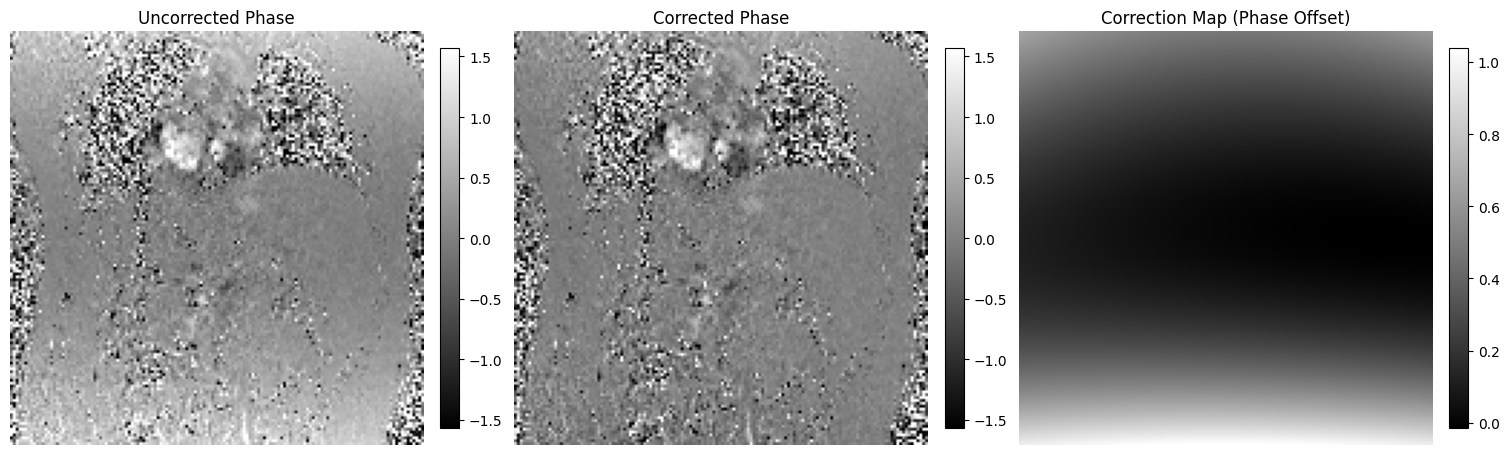

In [4]:
v = 0
t = 3
s = SPE // 2

print(f"showing v={v}, t={t}, s={s}")

sl_phase      = flow[v, t, s, :, :].T
sl_phase_corr = flow_corr[v, t, s, :, :].T

sl_corrmap = corr_maps[v, 0, s, :, :].T

sl_diff = sl_phase_corr - sl_phase

phase_vmin, phase_vmax = -np.pi / 2, np.pi / 2
diff_vmin, diff_vmax = -np.pi / 10, np.pi / 10

fig, ax = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

im00 = ax[0].imshow(sl_phase, cmap="gray", origin="lower", vmin=phase_vmin, vmax=phase_vmax)
ax[0].set_title("Uncorrected Phase")
ax[0].axis("off")
fig.colorbar(im00, ax=ax[0], fraction=0.046, pad=0.04)

im01 = ax[1].imshow(sl_phase_corr, cmap="gray", origin="lower", vmin=phase_vmin, vmax=phase_vmax)
ax[1].set_title("Corrected Phase")
ax[1].axis("off")
fig.colorbar(im01, ax=ax[1], fraction=0.046, pad=0.04)

im10 = ax[2].imshow(sl_corrmap, cmap="gray", origin="lower")
ax[2].set_title("Correction Map (Phase Offset)")
ax[2].axis("off")
fig.colorbar(im10, ax=ax[2], fraction=0.046, pad=0.04)

plt.show()